In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In this notebook, we will implement and compare the performance of U-net, UNet2+, UNet3+, and UNet# on a semantic segmentation task.

The corresponding original publications of these architectures are as follows:
* [Ronneberger, Fischer, Brox, U-Net: Convolutional Networks for Biomedical
Image Segmentation. **2015**](https://arxiv.org/pdf/1505.04597.pdf)
* [Zhou, Siddiquee, Tajbakhsh, Liang, UNet++: A Nested U-Net Architecture for Medical Image Segmentation. **2018**](https://arxiv.org/pdf/1807.10165.pdf)
* [Huang, Lin, Tong, Hu, Zhang, Iwamoto, Han, Chen, Wu, UNet 3+: A Full-Scale Connected UNet for Medical Image Segmentation. **2020**](https://arxiv.org/ftp/arxiv/papers/2004/2004.08790.pdf)
* [Qian, Zhou, Li, Hu, UNet#: A UNet-like Redesigning Skip Connections for Medical Image Segmentation. **2022**](https://arxiv.org/pdf/2205.11759.pdf)

The U-net architecture is well-established and widely known, so I will skip further explanation on this architecture. UNet2+, UNet3+, and UNet# optimize on the U-net architecture by redesigning the skip connections. Sometimes an image says more than a thousands words, and for that reason, I will show an image from the UNet# publication from Qian et al. to explain how they redesign the skip connections (the copyright of the image lies with Qia et al.):

![text](https://drive.google.com/uc?export=view&id=1dHwcw3gjWe_JScotcHTBLOk1mD93ra4B)

Implementations of U-net, UNet2+, and UNet3+ can already be widely found on Github. For UNet#, I have so far not yet found a public implementation on Github. Almost all of the available implementations them rather unelegantly hard-code the depth of the U-net. So if you want your net to be a bit shallower or deeper, you will have to modify the architecture.

In contrast, in this notebook we will abstract this and will in create functions that can create a list of nodes for U-net, UNet2+, UNet3+, and UNet# sharp architecture with variable depth. Then we will create a Pytorch module that can generically accept any of these node lists to create the respective architecture.

One caveat: For now, UNet2+, UNet3+, and UNet# architecture come without the "deep supervision" functionality described in the respective publications. I hope, some time down the road I will find time to add this functionality.

We will work with a dataset of microscope images of HeLa cells stably expressing H2b-GFP that has been publicized by the [Mitocheck consortium](https://www.mitocheck.org/) and can be found [here](http://celltrackingchallenge.net/2d-datasets/). I have already uploaded the corresponding zip-data file before to my drive that I mounted above, so we are ready to start.

Please note, that no thorough attempt to really optimize results was/is taken in this notebook as the main goal here is the implementations of the architectures. Also, the segmentation task might be a bit to easy to really see significant differences in the results of the different architectures.

In [2]:
!pip install imagecodecs
!pip install pytorch_lightning
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 44.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn import (
    Conv2d, ReLU, Sigmoid, BatchNorm2d, MaxPool2d, Upsample)
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint, EarlyStopping, LearningRateMonitor)
from pytorch_lightning.loggers import CSVLogger
from torchmetrics import JaccardIndex
from torchinfo import summary
import albumentations as A
from skimage import io
import copy
import zipfile
from PIL import Image
import cv2
from itertools import product
from dataclasses import dataclass, field
from typing import List
import math
import random
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

random.seed(2)
torch.manual_seed(2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Let's define some general hyperparameters upfront:

In [4]:
img_resized_shape = (1, 704, 1088)
patch_shape = (1, 352, 272) 

contractions = 3
filters_in = 1 # black and white images
filters_init = 16
cutoff = 0.5

batch_size = 8

# General training parameters
epochs = 160
patience_early_stopping = 60

lr_after_warmup = 3e-4
lr_decay = 0.98
lr_max = lr_after_warmup * 4
lr_min = 5e-8
warmup_epochs = 3
f_reduction = 0.25
f_restart = 1.25
patience = 3
min_loss_improvement = 0.005
no_of_restarts_init = 2
increment_no_of_restarts = 1

Extract the images from the zip file:

In [5]:
zip_path = "./drive/MyDrive/Fluo-N2DL-HeLa.zip"
dir_base = "./data"

with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(dir_base)

Let's have a look at one image and the corresponding segmentation mask. As you can see the mask are annotated for instance segmentation, we will however convert these annotations to binary labels (either background or object) to convert this into a semantic segmentation task:

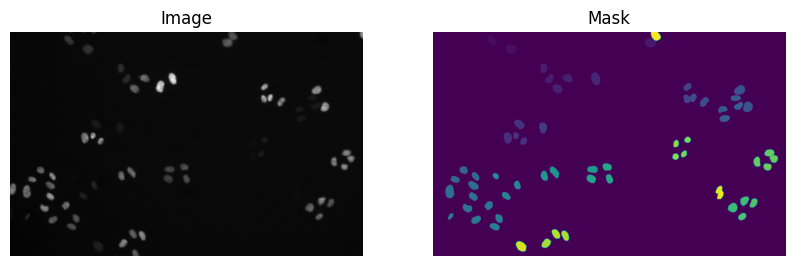

In [6]:
dir_imgs_orig = dir_base + "/Fluo-N2DL-HeLa/01/"
fps_imgs_orig = [dir_imgs_orig+x for x in next(os.walk(dir_imgs_orig))[2]]
fps_imgs_orig.sort()

fp_masks_orig = dir_base + "/Fluo-N2DL-HeLa/01_ST/SEG/"
fps_masks_orig = [fp_masks_orig+x for x in next(os.walk(fp_masks_orig))[2]]
fps_masks_orig.sort()

idx0 = 20
img1 = io.imread(fps_imgs_orig[idx0])
mask1 = io.imread(fps_masks_orig[idx0])

fig, ax = plt.subplots(1,2, figsize=(10, 8))
ax[0].imshow(img1, cmap="gray")
ax[0].set_title("Image")
ax[1].imshow(mask1)
ax[1].set_title("Mask")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

We will resized the images from 700x1100 pixels to 704x1088 so that they become usable for the U-net architectures:

In [7]:
dir_imgs = "./data/imgs/"
dir_masks = "./data/masks/"

[os.makedirs(x, exist_ok=True) for x in [dir_imgs, dir_masks]]

for fp_img, fp_mask in zip(fps_imgs_orig, fps_masks_orig):
    img = io.imread(fp_img).astype(np.float32)
    mask = io.imread(fp_mask).astype(np.float32)
   
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    transform = A.Compose([
        A.Resize(img_resized_shape[1], img_resized_shape[2], 
                  interpolation=cv2.INTER_NEAREST, p=1.0)])
    transformed = transform(image=img, mask=mask)
    img = transformed["image"]
    mask = transformed["mask"]
    
   
    np.save(dir_imgs + fp_img.split("/")[-1][:-4] + ".npy", 
            np.expand_dims(img, 2))
    np.save(dir_masks + fp_img.split("/")[-1][:-4] + ".npy", 
            np.expand_dims(mask, 2))

Next, we will split the data into train, validation and test data and patch them into patches of 352x272 pixels to ease the memory requirement:

In [8]:
def split_data(fns, train_ratio, val_ratio):
    test_ratio = 1 - train_ratio - val_ratio
    no_train_samples = int(len(fns) * train_ratio)
    no_test_samples =  int(len(fns) * test_ratio)
    
    idx_train = random.sample(range(len(fns)), no_train_samples)
    idx_val = [x for x in range(len(fns)) if x not in idx_train]
    idx_test = random.sample(idx_val, no_test_samples)
    idx_val = [x for x in idx_val if x not in idx_test]
    
    fns_train = [fns[x] for x in idx_train]
    fns_val = [fns[x] for x in idx_val]
    fns_test = [fns[x] for x in idx_test]   
    return fns_train, fns_val, fns_test


fns_imgs = [x for x in next(os.walk(dir_imgs))[2]]
fns_train, fns_val, fns_test = split_data(fns_imgs, 0.6, 0.2)


dir_train_imgs = "./data/train_imgs/"
dir_train_masks = "./data/train_masks/"

dir_val_imgs = "./data/val_imgs/"
dir_val_masks = "./data/val_masks/"

dir_test_imgs = "./data/test_imgs/"
dir_test_masks = "./data/test_masks/"


[os.makedirs(x, exist_ok=True) for x in [
    dir_train_imgs, dir_train_masks, 
    dir_val_imgs, dir_val_masks, 
    dir_test_imgs, dir_test_masks]]

         
def patchify(dir_in, fn_in, dir_out, patch_shape):
    for idx, fp in enumerate([dir_in+x for x in fn_in]):
        img = np.load(fp)
        no_patches_y = int(
            ((img.shape[1] - patch_shape[2]) / patch_shape[2]) + 1)
        no_patches_x = int(
            ((img.shape[0] - patch_shape[1]) / patch_shape[1]) + 1)
        
        for idx0, (idx1, idx2) in enumerate(
                product(range(no_patches_x), range(no_patches_y))):
           
            temp = img[(idx1 * patch_shape[1]):((idx1+1) * patch_shape[1]),
                        (idx2 * patch_shape[2]):((idx2+1) * patch_shape[2])]
            np.save(
                dir_out + fn_in[idx][:-4] + f"_patch{str(idx0).zfill(3)}.npy", 
                temp)
   
    
patchify(dir_imgs, fns_train, dir_train_imgs, patch_shape)
patchify(dir_masks, fns_train, dir_train_masks, patch_shape)

patchify(dir_imgs, fns_val, dir_val_imgs, patch_shape)
patchify(dir_masks, fns_val, dir_val_masks, patch_shape)

patchify(dir_imgs, fns_test, dir_test_imgs, patch_shape)
patchify(dir_masks, fns_test, dir_test_masks, patch_shape)

fps_train_imgs = [dir_train_imgs+x for x in next(os.walk(dir_train_imgs))[2]]
fps_train_masks = [dir_train_masks+x for x in next(os.walk(
    dir_train_masks))[2]]

fps_val_imgs = [dir_val_imgs+x for x in next(os.walk(dir_val_imgs))[2]]
fps_val_masks = [dir_val_masks+x for x in next(os.walk(dir_val_masks))[2]]

fps_test_imgs = [dir_test_imgs+x for x in next(os.walk(
    dir_test_imgs))[2]]
fps_test_masks = [dir_test_masks+x for x in next(os.walk(
    dir_test_masks))[2]]

Now, we will create a PyTorch dataset and visualize its output to make sure everything is working as planned:

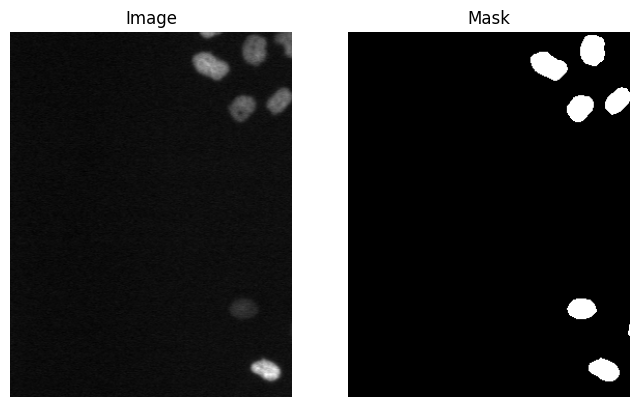

In [9]:
class CustomDataset(Dataset):
    def __init__(self, fps_imgs, fps_masks, augment=False):
        self.fps_imgs = fps_imgs
        self.fps_masks = fps_masks
        self.augment = augment

    def __len__(self):
        return len(self.fps_imgs)

    def __getitem__(self, idx):
        fp_img = self.fps_imgs[idx]
        fp_mask = self.fps_masks[idx]
        
        img = np.load(fp_img)
        mask = np.where(np.load(fp_mask) != 0, 1, 0)
        
        if self.augment:
            transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomCrop(
                    width=int(img.shape[1] * random.uniform(0.85, 1)), 
                    height=int(img.shape[0] * random.uniform(0.85, 1))),
                A.Resize(img.shape[0], img.shape[1]),
                A.ColorJitter(p=0.3)
                ])
            
            transformed = transform(image=img, mask=mask)
            img = transformed["image"]
            mask = transformed["mask"]
           
        img = torch.tensor(np.moveaxis(img, 2, 0)).float()
        mask = torch.tensor(np.moveaxis(mask, 2, 0)).float()
        return img, mask


ds_train = CustomDataset(fps_train_imgs, fps_train_masks, augment=False)
ds_val = CustomDataset(fps_val_imgs, fps_val_masks)
ds_test = CustomDataset(fps_test_imgs, fps_test_masks)

idx1 = 35
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
img2, mask2 = ds_train[idx1]
ax[0].imshow(img2.numpy()[0], cmap="gray")
ax[0].set_title("Image")
ax[1].imshow(mask2.numpy()[0], cmap="gray")
ax[1].set_title(f"Mask")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

I will use a custom learning rate scheduler in this notebook. You can use another scheduler if you do not like it.

In [10]:
class MultiplicativeDecayWithReduceOrRestartOnPlateau:
    def __init__(self, optimizer, lr_after_warmup, lr_decay, lr_max, lr_min, 
                 warmup_epochs, f_reduction, f_restart, patience, 
                 min_loss_improvement, no_of_restarts_init, 
                 increment_no_of_restarts):
        self.optimizer = optimizer
        self.lr_after_warmup = lr_after_warmup
        self.lr_decay = lr_decay
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.warmup_epochs = warmup_epochs
        self.f_reduction = f_reduction
        self.f_restart = f_restart
        self.patience = patience
        self.min_loss_improvement = min_loss_improvement
        self.no_of_restarts_init = no_of_restarts_init
        self.increment_no_of_restarts = increment_no_of_restarts
        
        self.loss_best = np.Inf
        self.plateau_epochs = 0
        self.reductions_counter = 0
        self.just_restarted = False
        self.set_par("initial_lr", self.lr_min)
        self.set_par("lr", self.lr_min)
        self.epoch = 0
        
    def get_par(self, name):
        for group in self.optimizer.param_groups: par = group[name]
        return par
    
    def set_par(self, name, value):
        for group in self.optimizer.param_groups: group[name] = value
        
    def on_loss_improvement(self, loss_cur):
        self.loss_best = loss_cur
        self.plateau_epochs = 0
    
    def on_loss_deterioration(self):
        self.plateau_epochs += 1
    
    def multiplicative_decay_lr(self, lr):
        return lr * self.lr_decay
    
    def on_plateau(self, lr):
        if self.reductions_counter >= self.no_of_restarts_init:
            lr_new = self.restart_lr()
        else:
            lr_new = self.steep_reduce_lr(lr)
        return lr_new

    def steep_reduce_lr(self, lr):
        lr_new = lr * self.f_reduction
        self.plateau_epochs = 0
        self.reductions_counter += 1
        return lr_new
    
    def restart_lr(self):
        self.lr_after_warmup *= self.f_restart
        lr_new = self.lr_after_warmup
        if lr_new > self.lr_max:
            lr_new = self.lr_max
        self.plateau_epochs = 0
        self.reductions_counter = 0
        self.no_of_restarts_init += self.increment_no_of_restarts
        self.just_restarted = True
        return lr_new

    def warmup(self):
        lr_new = self.lr_min + (self.lr_after_warmup - self.lr_min) * self.epoch / self.warmup_epochs
        return lr_new
    
    def step(self, metrics):
        if self.epoch <= self.warmup_epochs:
            lr_new = self.warmup()
        else:
            lr_cur = self.get_par("lr")
            loss_cur = float(metrics)
        
            if 1 - (loss_cur / self.loss_best) > self.min_loss_improvement:
                self.on_loss_improvement(loss_cur)
            else:
                self.on_loss_deterioration() 
            lr_new = self.multiplicative_decay_lr(lr_cur)
        
            if self.just_restarted:
                self.loss_best = loss_cur
                self.just_restarted = False
                
            if self.plateau_epochs >= self.patience:
                lr_new = self.on_plateau(lr_cur)

            if lr_new <= self.lr_min:
                lr_new = self.restart_lr()

        self.set_par("lr", lr_new)
        self.epoch += 1

# U-net

We create a node data class that for each node of the node architecture contains it i and j index (as defined in the image at the start of this notebook from Qia et al.). Furthmore it contains, the indices of inbound connections for each node in the node lists we will create subsequently. It also contains the "con_type" attribute that defines how many up- or downsampling operations have to be performed for each inbound connection defined in the "con_in" attribute. E.g., a +2 here means that two upsample operations have to be performed; a -1 means one downsample operation has to be performed, and a 0 means no up- or downsampling.

Next, we implement some functionality that creates a list of nodes for the U-net architecture. The content of this list is printed below to ease understanding.

In [11]:
@dataclass
class Node:
    i: int = None
    j: int = None
    con_in: List[int] = field(default_factory=list)
    con_type: List[int] = field(default_factory=list)
    f_in: int = None
    f_out: int = None


def find_idx_from_i_j(nodes, i, j):
    return [(x.i, x.j) for x in nodes].index((i, j))
    
    
def find_connections_unetsharp(nodes, cur_i, cur_j):
    con_in = []
    con_type = []
    f_in = 0
    f_out = []
    
    for node in nodes:
        if ((node.i - cur_i >= 1) & (node.i + node.j == cur_i + cur_j)) or (node.i == cur_i):
            idx = find_idx_from_i_j(nodes, node.i, node.j)
            con_in.append(idx)
            con_type.append(node.i - cur_i)
            f_in += nodes[idx].f_out
            f_out.append(nodes[idx].f_out)
    return con_in, con_type, f_in, min(f_out)


def create_nodes_unetsharp(contractions, filters_in, filters_init):
    nodes = []
    
    # Contraction
    nodes.append(Node(0, 0, [], [], filters_in, filters_init))
    for i in range(1, contractions+1):
        nodes.append(Node(
            i, 0, [i-1], [-1], filters_init * 2**(i-1), filters_init * 2**i))
    
    # Everything else
    for j in range(1, contractions+1):
        for i in range(contractions-j, -1, -1):
            con_in, con_type, f_in, f_out = find_connections_unetsharp(
                nodes, i, j)
            nodes.append(Node(i, j, con_in, con_type, f_in, f_out))
    return nodes


nodes1 = create_nodes_unetsharp(contractions, filters_in, filters_init)
_ = [print(x) for x in nodes1]

Node(i=0, j=0, con_in=[], con_type=[], f_in=1, f_out=16)
Node(i=1, j=0, con_in=[0], con_type=[-1], f_in=16, f_out=32)
Node(i=2, j=0, con_in=[1], con_type=[-1], f_in=32, f_out=64)
Node(i=3, j=0, con_in=[2], con_type=[-1], f_in=64, f_out=128)
Node(i=2, j=1, con_in=[2, 3], con_type=[0, 1], f_in=192, f_out=64)
Node(i=1, j=1, con_in=[1, 2], con_type=[0, 1], f_in=96, f_out=32)
Node(i=0, j=1, con_in=[0, 1], con_type=[0, 1], f_in=48, f_out=16)
Node(i=1, j=2, con_in=[1, 3, 4, 5], con_type=[0, 2, 1, 0], f_in=256, f_out=32)
Node(i=0, j=2, con_in=[0, 2, 5, 6], con_type=[0, 2, 1, 0], f_in=128, f_out=16)
Node(i=0, j=3, con_in=[0, 3, 4, 6, 7, 8], con_type=[0, 3, 2, 0, 1, 0], f_in=272, f_out=16)


This node list can now be passed to the generic UNet class to create the classical U-net architecture from Ronneberger et al.:

In [12]:
class UNetBlock(nn.Module):
    def __init__(self, filters_in, filters_out):
        super().__init__()
        self.conv1 = Conv2d(
            in_channels=filters_in, out_channels=filters_out, 
            kernel_size=3, stride=1, padding=1)
        self.conv2 = Conv2d(
            in_channels=filters_out, out_channels=filters_out, 
            kernel_size=3, stride=1, padding=1)
        self.activation = ReLU()
        self.bn1 = BatchNorm2d(filters_out)
        self.bn2 = BatchNorm2d(filters_out)
   
    def forward(self, x):
        x = torch.cat(x, dim=1)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.bn1(x)
        
        x = self.conv2(x)
        x = self.activation(x)
        x = self.bn2(x)
        return x


class Connector(nn.Module):
    def __init__(self):
        super().__init__()
   
    def forward(self, x, times=1):
        if times==0:
            return x
        if times>0:
            return Upsample(scale_factor=2 ** times, mode="bilinear")(x)
        if times<0:
            return MaxPool2d((2 ** abs(times), 2 ** abs(times)))(x)
    

class UNet(nn.Module):
    def __init__(self, nodes):
        super().__init__() 
        self.nodes = nodes
        self.layers = nn.ModuleList()
        self.build_layers()

    def build_layers(self):
        for node in self.nodes:
            self.layers.append(
                UNetBlock(filters_in=node.f_in, filters_out=node.f_out)
                )
        self.connector = Connector()
        self.final = Conv2d(
            in_channels=self.nodes[-1].f_out, out_channels=1, 
            kernel_size=3, stride=1, padding=1)
        self.sigmoid = Sigmoid() 
  
    def forward(self, x):
        out = []
        for idx, layer in enumerate(self.layers[0:16]):
            if idx==0:
                out.append(self.layers[idx]([x]))
            else:
                layer_input = [self.connector(out[x], y) for (x, y) in 
                               zip(self.nodes[idx].con_in, 
                                   self.nodes[idx].con_type)]
                out.append(self.layers[idx](layer_input))

        x = self.final(out[-1])
        x = self.sigmoid(x)
        return x


unet = UNet(nodes1)
# summary(unet, (1,) + patch_shape, depth=2)

We will PyTorch lightning to train the U-net:

In [13]:
cb_a1 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b1 = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_early_stopping)
cb_c1 = LearningRateMonitor(logging_interval="epoch")
logger1 = CSVLogger(save_dir="logs/", name="model001_unet", 
                    flush_logs_every_n_steps=1)


class UNetModule(pl.LightningModule):
    def __init__(self, net):
        super().__init__()
        self.automatic_optimization = False
        self.unet = net

    def forward(self, x):
        x = self.unet(x)
        return x
    
    def training_step(self, batch, batch_idx):
        opt = self.optimizers()
        opt.zero_grad()
        x, y = batch[0], batch[1]
        y_pred = self.forward(x)
        loss = F.binary_cross_entropy(y_pred, y, reduction="mean")
        
        # For logging loss & metrics
        self.log("train_loss", loss, on_step=False, on_epoch=True, 
                 prog_bar=False)
        self.manual_backward(loss)
        opt.step()
        return loss
        
    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y_pred = self.forward(x)
        loss = F.binary_cross_entropy(y_pred, y, reduction="mean")
        
        # For logging loss & metrics
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        if batch_idx == 0:
            self.cur_val_loss = []    
        self.cur_val_loss.append(loss)
        return loss
    
    def on_validation_epoch_end(self):
        # Take care of non-default scheduler
        self.cur_val_loss = torch.stack(self.cur_val_loss).mean()
        self.scheduler.step(self.cur_val_loss)
              
    def predict_step(self, batch, batch_idx):
        if isinstance(batch, list): # Dataloaders that return both X and y
            return self(batch[0]), batch[1]
        else: # Dataloaders that return only y
            return self(batch)
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=lr_min)
        self.scheduler = MultiplicativeDecayWithReduceOrRestartOnPlateau(
            optimizer=opt, lr_after_warmup=lr_after_warmup, lr_decay=lr_decay, 
            lr_max=lr_max, lr_min=lr_min, warmup_epochs=warmup_epochs,
            f_reduction=f_reduction, f_restart=f_restart, patience=patience, 
            min_loss_improvement=min_loss_improvement, 
            no_of_restarts_init=no_of_restarts_init, 
            increment_no_of_restarts=increment_no_of_restarts)
        return opt


model001 = UNetModule(unet)

trainer1a = pl.Trainer(
    max_epochs=epochs, check_val_every_n_epoch=1, 
    callbacks=[cb_a1, cb_b1, cb_c1], logger=logger1, accelerator="gpu", 
    devices=1, enable_progress_bar=False)

trainer1a.fit(
    model=model001, train_dataloaders=loader_train, val_dataloaders=loader_val)

Let's visualize the training progress:

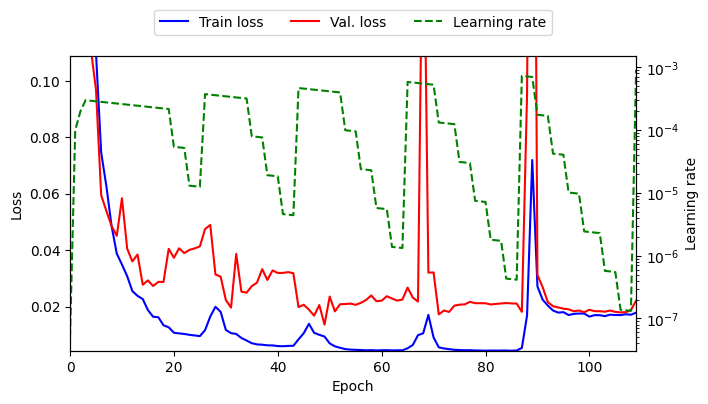

In [14]:
logs1 = pd.read_csv(Path(trainer1a.logger.log_dir + "/metrics.csv"))

def plot_training_progress(logs):
    epochs = logs.dropna(subset=["train_loss"])["epoch"]

    fig1, ax1 = plt.subplots(1, 1, figsize=(8, 5))
    l1 = ax1.plot(
        epochs, logs["train_loss"].dropna(), color="b", label="Train loss")
    l2 = ax1.plot(
        epochs, logs["val_loss"].dropna(), color="r", label="Val. loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_xlim(0, len(epochs)-1)

    loss_min1 = logs["train_loss"].min()
    loss_min2 = logs["val_loss"].min()
    ax1.set_ylim(loss_min1, loss_min2*8)
    ax2 = ax1.twinx() 
    l3 = ax2.plot(
        epochs, logs["lr-Adam"].dropna(), color="g", linestyle="dashed", 
        label="Learning rate")
    ax2.set_ylabel("Learning rate")
    ax2.set_yscale("log")
    ax1.legend(l1+l2+l3, [l.get_label() for l in l1+l2+l3], loc="lower center", 
              bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3)
    plt.tight_layout(pad=4)
    plt.show()


plot_training_progress(logs1)

And evaluate results of the classical U-net on the test data:

In [15]:
checkpoint_file = trainer1a.checkpoint_callback.best_model_path
model001 = model001.load_from_checkpoint(checkpoint_file, net=unet)
model001.eval()

trainer1b = pl.Trainer(accelerator="gpu", devices=1, enable_progress_bar=False)
y_test_out1 = trainer1b.predict(model=model001, dataloaders=loader_test)
y_test_pred1 = torch.where(torch.cat([x[0] for x in y_test_out1]) > cutoff, 1, 0)
y_test1 = torch.cat([x[1] for x in y_test_out1])

jaccard = JaccardIndex(task="binary", num_classes=2)
result1 = jaccard(y_test_pred1, y_test1).numpy()
print(f"The mean intersection-over-union on the test set for the classical U-net is: {result1:.3f}.")

The mean intersection-over-union on the test set for the classical U-net is: 0.935.


We will also look at one exemplary prediction:

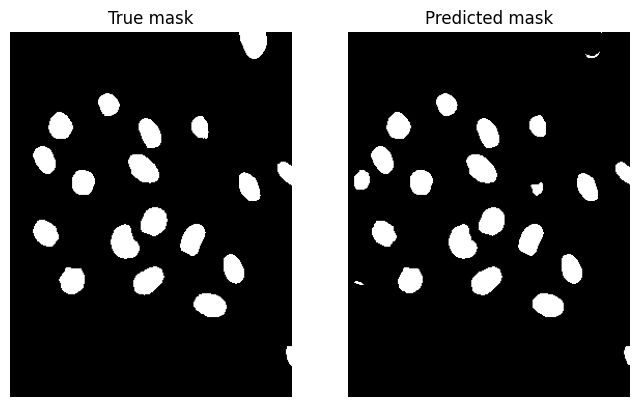

In [16]:
idx2 = 35

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(y_test1.numpy()[idx2, 0, :, :], cmap="gray")
ax[0].set_title("True mask")
ax[1].imshow(y_test_pred1.numpy()[idx2, 0, :, :], cmap="gray")
ax[1].set_title(f"Predicted mask")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

# UNet2+

Now, let's do the same with UNet2+:

In [17]:
def find_connections_unet2plus(nodes, cur_i, cur_j):
    con_in = []
    con_type = []
    f_in = 0
    f_out = []
    
    for node in nodes:
        if ((node.i - cur_i == 1) & (node.i + node.j == cur_i + cur_j)) or (node.i == cur_i):
            idx = find_idx_from_i_j(nodes, node.i, node.j)
            con_in.append(idx)
            con_type.append(node.i - cur_i)
            f_in += nodes[idx].f_out
            f_out.append(nodes[idx].f_out)
    return con_in, con_type, f_in, min(f_out)


def create_nodes_unet2plus(contractions, filters_in, filters_init):
    nodes = []
    
    # Contraction
    nodes.append(Node(0, 0, [], [], filters_in, filters_init))
    for i in range(1, contractions+1):
        nodes.append(Node(
            i, 0, [i-1], [-1], filters_init * 2**(i-1), filters_init * 2**i))
    
    # Everything else
    for j in range(1, contractions+1):
        for i in range(contractions-j, -1, -1):
            con_in, con_type, f_in, f_out = find_connections_unet2plus(
                nodes, i, j)
            nodes.append(Node(i, j, con_in, con_type, f_in, f_out))
    return nodes


nodes2 = create_nodes_unet2plus(contractions, filters_in, filters_init)
_ = [print(x) for x in nodes2]

Node(i=0, j=0, con_in=[], con_type=[], f_in=1, f_out=16)
Node(i=1, j=0, con_in=[0], con_type=[-1], f_in=16, f_out=32)
Node(i=2, j=0, con_in=[1], con_type=[-1], f_in=32, f_out=64)
Node(i=3, j=0, con_in=[2], con_type=[-1], f_in=64, f_out=128)
Node(i=2, j=1, con_in=[2, 3], con_type=[0, 1], f_in=192, f_out=64)
Node(i=1, j=1, con_in=[1, 2], con_type=[0, 1], f_in=96, f_out=32)
Node(i=0, j=1, con_in=[0, 1], con_type=[0, 1], f_in=48, f_out=16)
Node(i=1, j=2, con_in=[1, 4, 5], con_type=[0, 1, 0], f_in=128, f_out=32)
Node(i=0, j=2, con_in=[0, 5, 6], con_type=[0, 1, 0], f_in=64, f_out=16)
Node(i=0, j=3, con_in=[0, 6, 7, 8], con_type=[0, 0, 1, 0], f_in=80, f_out=16)


In [18]:
unet2plus = UNet(nodes2)
model002 = UNetModule(unet2plus)

cb_a2 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b2 = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_early_stopping)
cb_c2 = LearningRateMonitor(logging_interval="epoch")
logger2 = CSVLogger(save_dir="logs/", name="model002_unet2plus", 
                    flush_logs_every_n_steps=1)

trainer2a = pl.Trainer(
    max_epochs=epochs, check_val_every_n_epoch=1, 
    callbacks=[cb_a2, cb_b2, cb_c2], logger=logger2, accelerator="gpu", 
    devices=1, enable_progress_bar=False)

trainer2a.fit(
    model=model002, train_dataloaders=loader_train, val_dataloaders=loader_val)

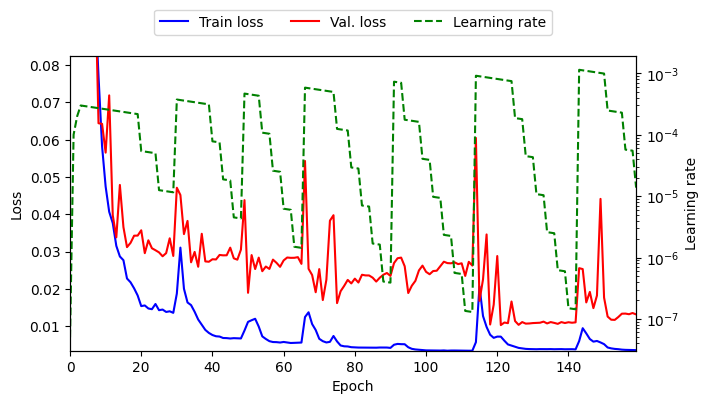

In [19]:
logs2 = pd.read_csv(Path(trainer2a.logger.log_dir + "/metrics.csv"))
plot_training_progress(logs2)

In [20]:
checkpoint_file = trainer2a.checkpoint_callback.best_model_path
model002 = model002.load_from_checkpoint(checkpoint_file, net=unet2plus)
model002.eval()

trainer2b = pl.Trainer(accelerator="gpu", devices=1, enable_progress_bar=False)
y_test_out2 = trainer2b.predict(model=model002, dataloaders=loader_test)
y_test_pred2 = torch.where(torch.cat([x[0] for x in y_test_out2]) > cutoff, 1, 0)
y_test2 = torch.cat([x[1] for x in y_test_out2])

jaccard = JaccardIndex(task="binary", num_classes=2)
result2 = jaccard(y_test_pred2, y_test2).numpy()
print(f"The mean intersection-over-union on the test set for the UNet2+ is: {result2:.3f}.")

The mean intersection-over-union on the test set for the UNet2+ is: 0.944.


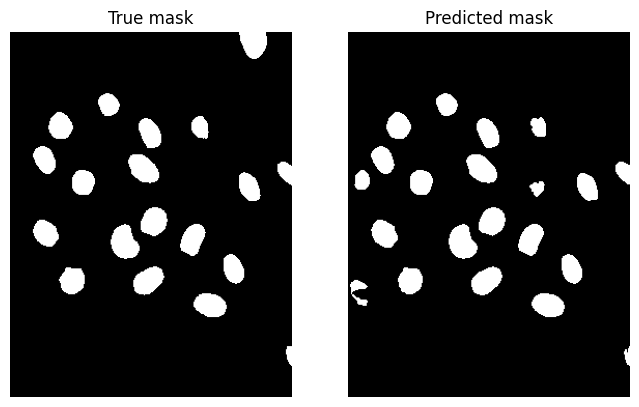

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(y_test2.numpy()[idx2, 0, :, :], cmap="gray")
ax[0].set_title("True mask")
ax[1].imshow(y_test_pred2.numpy()[idx2, 0, :, :], cmap="gray")
ax[1].set_title(f"Predicted mask")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

# UNet3+

In [22]:
def find_connections_unet3plus(nodes, cur_i, cur_j):
    con_in = []
    con_type = []
    f_in = 0
    
    for node in nodes:
        if ((node.i - cur_i >= 1) & (node.i + node.j == cur_i + cur_j)) or (node.i <= cur_i):
            idx1 = find_idx_from_i_j(nodes, node.i, node.j)
            con_in.append(idx1)
            con_type.append(node.i - cur_i)
            f_in += nodes[idx1].f_out
            
            idx2 = find_idx_from_i_j(nodes, node.i, 0)
            f_out = nodes[idx2].f_in
            
    return con_in, con_type, f_in, f_out


def create_nodes_unet3plus(contractions, filters_in, filters_init):
    nodes = []
    
    # Contraction
    nodes.append(Node(0, 0, [], [], filters_in, filters_init))
    for i in range(1, contractions+1):
        nodes.append(Node(
            i, 0, [i-1], [-1], filters_init * 2**(i-1), filters_init * 2**i))
    
    # Everything else
    for j in range(1, contractions+1):
        i = contractions - j 
        con_in, con_type, f_in, f_out = find_connections_unet3plus(
            nodes, i, j)
        nodes.append(Node(i, j, con_in, con_type, f_in, f_out))

    return nodes


nodes3 = create_nodes_unet3plus(contractions, filters_in, filters_init)
_ = [print(x) for x in nodes3]

Node(i=0, j=0, con_in=[], con_type=[], f_in=1, f_out=16)
Node(i=1, j=0, con_in=[0], con_type=[-1], f_in=16, f_out=32)
Node(i=2, j=0, con_in=[1], con_type=[-1], f_in=32, f_out=64)
Node(i=3, j=0, con_in=[2], con_type=[-1], f_in=64, f_out=128)
Node(i=2, j=1, con_in=[0, 1, 2, 3], con_type=[-2, -1, 0, 1], f_in=240, f_out=64)
Node(i=1, j=2, con_in=[0, 1, 3, 4], con_type=[-1, 0, 2, 1], f_in=240, f_out=32)
Node(i=0, j=3, con_in=[0, 3, 4, 5], con_type=[0, 3, 2, 1], f_in=240, f_out=16)


In [23]:
unet3plus = UNet(nodes3)
model003 = UNetModule(unet3plus)

cb_a3 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b3 = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_early_stopping)
cb_c3 = LearningRateMonitor(logging_interval="epoch")
logger3 = CSVLogger(save_dir="logs/", name="model003_unet3plus", 
                    flush_logs_every_n_steps=1)

trainer3a = pl.Trainer(
    max_epochs=epochs, check_val_every_n_epoch=1, 
    callbacks=[cb_a3, cb_b3, cb_c3], logger=logger3, accelerator="gpu", 
    devices=1, enable_progress_bar=False)

trainer3a.fit(
    model=model003, train_dataloaders=loader_train, val_dataloaders=loader_val)

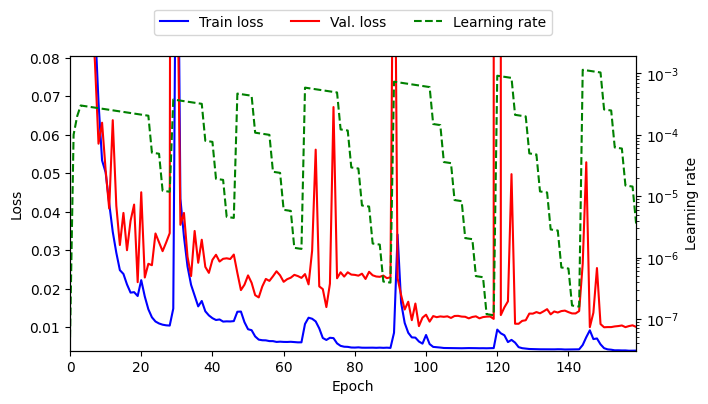

In [24]:
logs3 = pd.read_csv(Path(trainer3a.logger.log_dir + "/metrics.csv"))
plot_training_progress(logs3)

In [25]:
checkpoint_file = trainer3a.checkpoint_callback.best_model_path
model003 = model003.load_from_checkpoint(checkpoint_file, net=unet3plus)
model003.eval()

trainer3b = pl.Trainer(accelerator="gpu", devices=1, enable_progress_bar=False)
y_test_out3 = trainer3b.predict(model=model003, dataloaders=loader_test)
y_test_pred3 = torch.where(torch.cat([x[0] for x in y_test_out3]) > cutoff, 1, 0)
y_test3 = torch.cat([x[1] for x in y_test_out3])

jaccard = JaccardIndex(task="binary", num_classes=2)
result3 = jaccard(y_test_pred3, y_test3).numpy()
print(f"The mean intersection-over-union on the test set for the UNet3+ is: {result3:.3f}.")

The mean intersection-over-union on the test set for the UNet3+ is: 0.956.


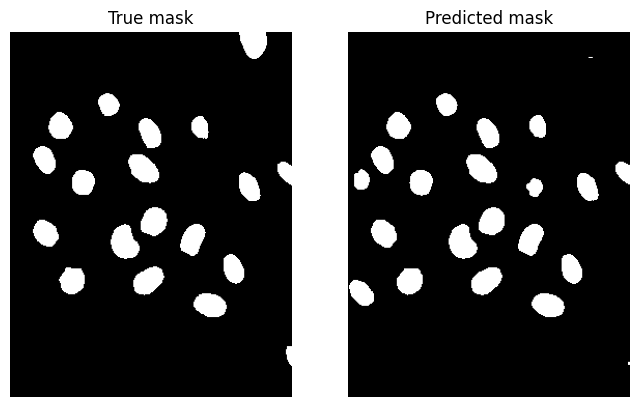

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(y_test3.numpy()[idx2, 0, :, :], cmap="gray")
ax[0].set_title("True mask")
ax[1].imshow(y_test_pred3.numpy()[idx2, 0, :, :], cmap="gray")
ax[1].set_title(f"Predicted mask")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

# UNetsharp


In [27]:
def find_connections_unetsharp(nodes, cur_i, cur_j):
    con_in = []
    con_type = []
    f_in = 0
    f_out = []
    
    for node in nodes:
        if ((node.i - cur_i >= 1) & (node.i + node.j == cur_i + cur_j)) or (node.i == cur_i):
            idx = find_idx_from_i_j(nodes, node.i, node.j)
            con_in.append(idx)
            con_type.append(node.i - cur_i)
            f_in += nodes[idx].f_out
            f_out.append(nodes[idx].f_out)
    return con_in, con_type, f_in, min(f_out)


def create_nodes_unetsharp(contractions, filters_in, filters_init):
    nodes = []
    
    # Contraction
    nodes.append(Node(0, 0, [], [], filters_in, filters_init))
    for i in range(1, contractions+1):
        nodes.append(Node(
            i, 0, [i-1], [-1], filters_init * 2**(i-1), filters_init * 2**i))
    
    # Everything else
    for j in range(1, contractions+1):
        for i in range(contractions-j, -1, -1):
            con_in, con_type, f_in, f_out = find_connections_unetsharp(
                nodes, i, j)
            nodes.append(Node(i, j, con_in, con_type, f_in, f_out))
    return nodes


nodes4 = create_nodes_unetsharp(contractions, filters_in, filters_init)


_ = [print(x) for x in nodes4]

Node(i=0, j=0, con_in=[], con_type=[], f_in=1, f_out=16)
Node(i=1, j=0, con_in=[0], con_type=[-1], f_in=16, f_out=32)
Node(i=2, j=0, con_in=[1], con_type=[-1], f_in=32, f_out=64)
Node(i=3, j=0, con_in=[2], con_type=[-1], f_in=64, f_out=128)
Node(i=2, j=1, con_in=[2, 3], con_type=[0, 1], f_in=192, f_out=64)
Node(i=1, j=1, con_in=[1, 2], con_type=[0, 1], f_in=96, f_out=32)
Node(i=0, j=1, con_in=[0, 1], con_type=[0, 1], f_in=48, f_out=16)
Node(i=1, j=2, con_in=[1, 3, 4, 5], con_type=[0, 2, 1, 0], f_in=256, f_out=32)
Node(i=0, j=2, con_in=[0, 2, 5, 6], con_type=[0, 2, 1, 0], f_in=128, f_out=16)
Node(i=0, j=3, con_in=[0, 3, 4, 6, 7, 8], con_type=[0, 3, 2, 0, 1, 0], f_in=272, f_out=16)


In [28]:
unetsharp = UNet(nodes4)
model004 = UNetModule(unetsharp)

cb_a4 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b4 = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_early_stopping)
cb_c4 = LearningRateMonitor(logging_interval="epoch")
logger4 = CSVLogger(save_dir="logs/", name="model004_unetsharp", 
                    flush_logs_every_n_steps=1)

trainer4a = pl.Trainer(
    max_epochs=epochs, check_val_every_n_epoch=1, 
    callbacks=[cb_a4, cb_b4, cb_c4], logger=logger4, accelerator="gpu", 
    devices=1, enable_progress_bar=False)

trainer4a.fit(
    model=model004, train_dataloaders=loader_train, val_dataloaders=loader_val)

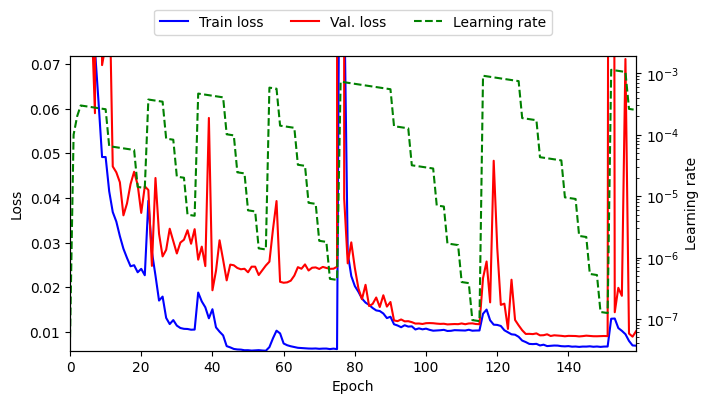

In [29]:
logs4 = pd.read_csv(Path(trainer4a.logger.log_dir + "/metrics.csv"))
plot_training_progress(logs4)

In [30]:
checkpoint_file = trainer4a.checkpoint_callback.best_model_path
model004 = model004.load_from_checkpoint(checkpoint_file, net=unetsharp)
model004.eval()

trainer4b = pl.Trainer(accelerator="gpu", devices=1, enable_progress_bar=False)
y_test_out4 = trainer4b.predict(model=model004, dataloaders=loader_test)
y_test_pred4 = torch.where(torch.cat([x[0] for x in y_test_out4]) > cutoff, 1, 0)
y_test4 = torch.cat([x[1] for x in y_test_out4])

jaccard = JaccardIndex(task="binary", num_classes=2)
result4 = jaccard(y_test_pred4, y_test4).numpy()
print(f"The mean intersection-over-union on the test set for the UNet# is: {result4:.3f}.")

The mean intersection-over-union on the test set for the UNet# is: 0.950.


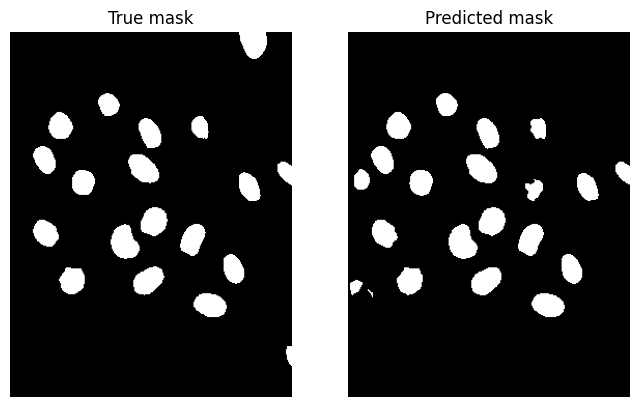

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(y_test4.numpy()[idx2, 0, :, :], cmap="gray")
ax[0].set_title("True mask")
ax[1].imshow(y_test_pred4.numpy()[idx2, 0, :, :], cmap="gray")
ax[1].set_title(f"Predicted mask")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

# Summary

In [32]:
print("Mean intersection-over-union on test data:")
print(f"Classical U-net: {result1:.3f}")
print(f"UNet2+: {result2:.3f}")
print(f"UNet3+: {result3:.3f}")
print(f"UNet#: {result4:.3f}")

Mean intersection-over-union on test data:
Classical U-net: 0.935
UNet2+: 0.944
UNet3+: 0.956
UNet#: 0.950
